# Listen, Attend and Spell
https://arxiv.org/abs/1508.01211

## Dataset

About this resource:
Aishell is an open-source Chinese Mandarin speech corpus published by Beijing Shell Shell Technology Co.,Ltd.

400 people from different accent areas in China are invited to participate in the recording, which is conducted in a quiet indoor environment using high fidelity microphone and downsampled to 16kHz. The manual transcription accuracy is above 95%, through professional speech annotation and strict quality inspection. The data is free for academic use. We hope to provide moderate amount of data for new researchers in the field of speech recognition. 

In [0]:
!wget http://www.openslr.org/resources/33/data_aishell.tgz
!tar -C /content/ -xf /content/data_aishell.tgz

--2019-12-17 03:32:24--  http://www.openslr.org/resources/33/data_aishell.tgz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15582913665 (15G) [application/x-gzip]
Saving to: ‘data_aishell.tgz’

data_aishell.tgz    100%[===================>]  14.51G  20.4MB/s    in 12m 52s 

2019-12-17 03:45:16 (19.2 MB/s) - ‘data_aishell.tgz’ saved [15582913665/15582913665]



In [11]:
import os
import random
import IPython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# !pip install torchaudio
# import torchaudio
# from torchaudio.transforms import Spectrogram

!pip install torchviz
from torchviz import make_dot

### Dataset Splitting and Analysis



In [0]:
!mkdir /content/train_data
!mkdir /content/test_data

wav_dir = os.path.join('/content', 'data_aishell', 'wav')
transcript_dir = os.path.join('/content', 'data_aishell', 'transcript')
train_dir = os.path.join('/content', 'train_data')
test_dir = os.path.join('/content', 'test_data')

In [0]:
# read the transcript
with open(os.path.join(transcript_dir, 'aishell_transcript_v0.8.txt')) as f:
    data_list = f.readlines()

data = []
for example in data_list:
    id_, sent = str(example.split(' ')[0]), str(' '.join(example.split(' ')[1:-1])) # -1 to remove '\n'
    data.append((id_, sent))

print('Num examples:', len(data))
data_df = pd.DataFrame(data, columns=['id', 'sent'])
data_df.head()

Num examples: 141600


,id,sent
0,BAC009S0002W0122,而 对 楼市 成交 抑制 作用 最 大 的 限
1,BAC009S0002W0123,也 成为 地方 政府 的 眼中
2,BAC009S0002W0124,自 六月 底 呼和浩特 市 率先 宣布 取消 限 购
3,BAC009S0002W0125,各地 政府 便 纷纷
4,BAC009S0002W0126,仅 一 个 多 月 的 时间


In [0]:
from sklearn.model_selection import train_test_split

split = False
if not split:   # to avoid splitting again by mistake
    train_df, test_df = train_test_split(data_df, test_size=0.05)
    split = True
num_training = train_df.shape[0]
num_testing = test_df.shape[0]
print('Num Training Examples:', num_training)
print('Num Testing Examples:', num_testing)

Num Training Examples: 134520
Num Testing Examples: 7080


In [0]:
# move all files to one folder, for easy distribution
!mkdir /content/dataset
!for file in /content/data_aishell/wav/*; do tar -C /content/dataset/ -xf "$file" ; echo "$file" ; done
!for file in /content/dataset/train/*; do mv "$file"/* /content/dataset/; done
!for file in /content/dataset/test/*; do mv "$file"/* /content/dataset/; done
!for file in /content/dataset/dev/*; do mv "$file"/* /content/dataset/; done

Sentence : 保障 房 与 经 适 房 的
Shape : torch.Size([1, 201, 284])


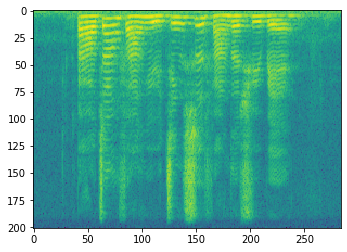

In [0]:
idx = random.randint(0, num_training)

clip, sent = train_df.iloc[idx]
clip_path = os.path.join(dataset_dir, clip+'.wav')
print('Sentence :', sent)

spec = Spectrogram()    # Draw spectrogram
waveform, _ = torchaudio.load(clip_path)
clip_specgram = spec(waveform)
plt.imshow(clip_specgram[0,:,:].log2())
print('Shape :', clip_specgram.shape)

IPython.display.Audio(clip_path)    # play audio

Printed and verified the correctness of data using Google Translate.

### Preprocessing

#### Upload to Drive

### Dataset Class

### Model

#### Listener

In [0]:
class Listener(nn.Module):
    """
        Multi-layer LSTM with pyramidal structure 
        Performs time down sampling by factor 2 on every layer
    """
    def __init__(self, input_size, hidden_size, dropout=0.0, 
                 bidirectional=True, batch_first=True):
     
        super(Listener, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_first = batch_first

        # TODO : Make it bidirectional
        # TODO : Add code to handle, odd shaped inputs
        self.lstm1 = nn.LSTM(input_size, hidden_size, 
                             dropout=dropout, batch_first=batch_first)
                             #bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_size*2, hidden_size,
                             dropout=dropout, batch_first=batch_first)
                             #bidirectional=True)
        self.lstm3 = nn.LSTM(hidden_size*2, hidden_size,
                             dropout=dropout, batch_first=batch_first)
                             #bidirectional=True)
    
    def forward(self, x_padded):
        """
            Parameters: x_padded - padded sequence of input (T, batch_size, input_size)
                      : x_lens - true lengths of sequences (batch_size,)
        """
        if not self.training:
            self.lstm1.flatten_parameters()
            self.lstm2.flatten_parameters()
            self.lstm3.flatten_parameters()
        
        out1, _ = self.lstm1(x_padded)
        out1 = self.downsample_time(out1)   # downsample
        out2, _ = self.lstm2(out1)
        out2 = self.downsample_time(out2)   # downsample
        out3, _ = self.lstm2(out2)

        return out3


    def downsample_time(self, out):
        """
            Divides the number of timesteps of outby 2
            concatenate the output form previous layer
        """
        assert(out.shape[0] % 2 == 0)
        if self.batch_first:
            b, t, h = out.shape
            out = out.reshape(b, int(t/2), int(h*2)).contiguous()
        else:    
            t, b, h = out.shape
            out = out.view(int(t/2), b, int(h*2)).contiguous()
        return out

In [60]:
x = torch.rand((32, 64, 10))    # (N, Tx, H)
l = Listener(10, [5, 5, 5])
out = l(x)
print(out.shape)

torch.Size([32, 16, 5])


#### Attend and Spell

In [0]:
class Attention(nn.Module):

    def __init__(self, n_h, n_s):
        super(Attention, self).__init__()
        self.linear1 = nn.Linear(n_h + n_s, 1) 
        #self.linear2 = nn.Linear(hidden_size, 1)
        
    def forward(self, h, s_prev):
        """
        Args:
            h -- endoder output (N, Tx, n_h)
            s_prev -- previous hidden state of the Decoder (N, n_s)
        """        
        Tx = h.shape[1] # batch size, N
        s_prev = s_prev.unsqueeze(dim=1).expand(-1, Tx, -1)   # (N, Tx, n_s)
        concat = torch.cat([h, s_prev], dim=2)  

        energies = F.relu(self.linear1(concat))     # (N, Tx, 1)
        alphas = F.softmax(energies, dim=1)    # sum(alphas) = 1, over Tx axis
        
        context = torch.bmm(alphas.squeeze().unsqueeze(dim=1), h)  # (N, 1, Tx)*(N, Tx, n_h)->(N, 1, n_h)
        return context.squeeze(dim=1)

In [0]:
class AttendAndSpell(nn.Module):
    """ 
        Decodes text from encoded voice
    """

    def __init__(self, hidden_size, encoder_out_size, vocab_size):
        """
            hidden_size: units in LSTM cell
            encoder_out_size: dim of encoder output
            vocab_size: dim of softmax output
                        # In ASR, number of distinct characters 
        """
        super(AttendAndSpell, self).__init__()    
        
        self.hidden_size = hidden_size
        self.n_h = encoder_out_size
        self.n_s = hidden_size
        self.vocab_size = vocab_size       

        self.attention_layer = Attention(self.n_h, self.n_s)
        self.lstm_cell = nn.LSTMCell(self.n_h + self.vocab_size, self.hidden_size)
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_size + self.n_h, vocab_size),
            nn.Softmax(dim=1)
        )

    def forward(self, yt_prev, s_prev, encoder_output, c_prev):
        """
            Decode a singel time step
        """
        # s_i = RNN(y_i-1, c_i-1, s_i-1)
        yt_prev = F.one_hot(yt_prev, num_classes=self.vocab_size).to(torch.float32)
        rnn_input = torch.cat([yt_prev, c_prev], dim=1)
        s  = self.lstm_cell(rnn_input, s_prev)

        # context vector: c_i = AttentionContext(s_i, h)
        c = self.attention_layer(encoder_output, s[0])
        
        # concat s_i and c_i and feed to mlp
        mlp_input = torch.cat([s[0], c], dim=1)
        out = self.mlp(mlp_input)
        return out, s, c

In [155]:
# checking the decoder
encoder_out_size = 6
hid_sz = 10
vocab_size = 5
h = torch.rand((32, 8, encoder_out_size))  # (N, Tx/8, encoder_out_size)

decoder = AttendAndSpell(hid_sz, encoder_out_size, 5)

y = torch.randint(0, vocab_size, (32,)) # <sos>
s = (torch.zeros((32, hid_sz)), torch.zeros((32, hid_sz)))
c = torch.zeros(32, encoder_out_size)

output = []
for i in range(5):
    out, s, c = decoder(y, s, h, c)
    print(out.shape)
    output.append(out)

torch.Size([32, 5])
torch.Size([32, 5])
torch.Size([32, 5])
torch.Size([32, 5])
torch.Size([32, 5])


#### Seq2Seq

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, tf_ratio):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.tf_ratio = tf_ratio

        self.loss = nn.CrossEntropyLoss()

    def forward(self, data, target):
        X, Y = data, target
        Ty = Y.shape[1]
        
        encoder_output = self.encoder(data)
        
        # initialising loss for batch
        loss = 0.0

        y_in = Y[:,0] # <sos>
        s = (torch.zeros((32, decoder.hidden_size)), 
            torch.zeros((32, decoder.hidden_size)))
        c = torch.zeros(32, decoder.n_h)

        for t in range(1, Ty):
            target = Y[:, t]
            y_out, s, c = self.decoder(y_in, s, encoder_output, c)
            loss += self.loss(y_out, target)
            teacher_force = random.random() < self.tf_ratio
            y_in = target if teacher_force else y_out.max(dim=1)[1]
        return loss

In [145]:
hid_sz = 10
embed_size = 4
vocab_size = 4
ip_size = 40
encoder = Listener(ip_size, 20)
decoder = AttendAndSpell(hid_sz, encoder.hidden_size, vocab_size)

X = torch.rand((32, 64, ip_size))
Y = torch.randint(0, vocab_size, (32, 10))

s2s = Seq2Seq(encoder, decoder, tf_ratio = 0.0)
s2s(X, Y)

tensor(12.4802, grad_fn=<AddBackward0>)

#### Handle, DEVICE of tensors created

### Train utils

### Training

### Rough

In [0]:
# stacking lstm layers to form a pyramidal structure
#from torch.nn import Sequential
#

lstm1 = nn.LSTM(50, 40, bidirectional=True)
lstm2 = nn.LSTM(40*2, 20, bidirectional=True)
lstm3 = nn.LSTM(20*2, 10, bidirectional=True)

In [0]:
x = torch.rand((400, 32, 50))
out, hidden = lstm1(x)
print(out.shape)
out, _ = lstm2(out)
print(out.shape)
out, _ = lstm3(out)
print(out.shape)

torch.Size([400, 32, 80])
torch.Size([400, 32, 40])
torch.Size([400, 32, 20])


In [0]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pack_sequence

y =[]
y.append(torch.ones((4)))
y.append(torch.ones((3)))
y.append(torch.ones((2)))
Y = pack_sequence(y, enforce_sorted=True)
print(Y)
q, _ = pad_packed_sequence(Y, batch_first=True)
print(q)

PackedSequence(data=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=None, unsorted_indices=None)
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 0.],
        [1., 1., 0., 0.]])


In [32]:
lc = nn.LSTMCell(10, 10)

ip = torch.rand((32, 10))
h0 = torch.zeros((32, 10))
c0 = torch.zeros((32, 10))

hx, cx = lc(ip, (h0, c0))
print(hx.shape, cx.shape)

torch.Size([32, 10]) torch.Size([32, 10])
